In [24]:
import yfinance as yf
import pandas as pd

### Getting the data

In [46]:
tsla = yf.Ticker("tsla")

In [47]:
tsla

yfinance.Ticker object <TSLA>

In [48]:
tsla_historical = tsla.history(period="max")

In [49]:
tsla_historical.index = tsla_historical.index.date

In [50]:
tsla_historical.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2024-06-24,184.970001,188.800003,182.550003,182.580002,61992100,0.0,0.0
2024-06-25,184.399994,187.970001,182.009995,187.350006,63678300,0.0,0.0
2024-06-26,186.539993,197.759995,186.360001,196.369995,95737100,0.0,0.0
2024-06-27,195.169998,198.720001,194.050003,197.419998,72746500,0.0,0.0
2024-06-28,199.550003,203.199997,195.259995,197.880005,95302700,0.0,0.0


In [51]:
# Only get the closing price for each day
tsla_prices = pd.DataFrame(tsla_historical["Close"]).rename(columns={"Close": "Price"})
tsla_prices.head()

,Price
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


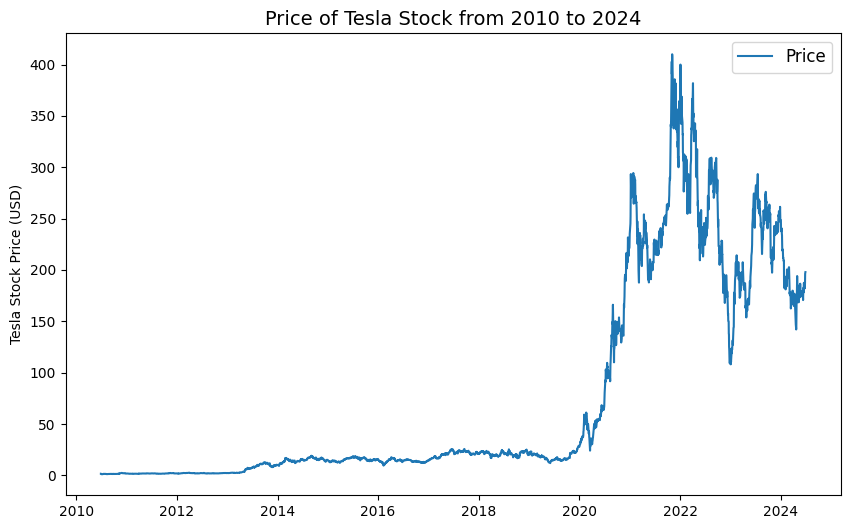

In [53]:
import matplotlib.pyplot as plt
tsla_prices.plot(figsize=(10, 6))
plt.ylabel("Tesla Stock Price (USD)")
plt.title("Price of Tesla Stock from 2010 to 2024", fontsize=14)
plt.legend(fontsize=12);

### Create train and test sets

In [56]:
# Get timesteps and price
timesteps = tsla_prices.index.to_numpy()
prices = tsla_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array([datetime.date(2010, 6, 29), datetime.date(2010, 6, 30),
        datetime.date(2010, 7, 1), datetime.date(2010, 7, 2),
        datetime.date(2010, 7, 6), datetime.date(2010, 7, 7),
        datetime.date(2010, 7, 8), datetime.date(2010, 7, 9),
        datetime.date(2010, 7, 12), datetime.date(2010, 7, 13)],
       dtype=object),
 array([1.59266698, 1.58866704, 1.46399999, 1.27999997, 1.074     ,
        1.05333304, 1.16400003, 1.15999997, 1.13666701, 1.20933294]))

In [62]:
# Setting the split size
split_size = int(0.9 * len(prices))

# Splitting for time series data
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(3171, 353, 3171, 353)

In [77]:
# Create time series plot function
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Tesla Stock Price (USD)")
    if label:
        plt.legend(fontsize=10)
    plt.grid(True)

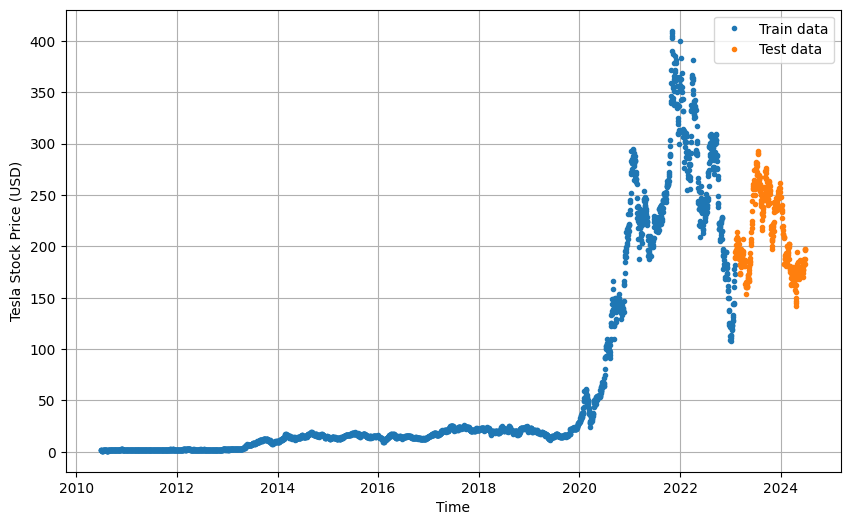

In [78]:
plt.figure(figsize=(10, 6))
plot_time_series(timesteps=X_train, 
                 values=y_train,
                 label="Train data")
plot_time_series(timesteps=X_test, 
                 values=y_test,
                 label="Test data")

### Baseline model

In [79]:
# Naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([188.27000427, 189.97999573, 194.75999451, 196.80999756,
        201.28999329, 207.32000732, 196.88999939, 194.63999939,
        209.25      , 214.24000549]),
 array([182.47000122, 178.00999451, 187.44000244, 184.86000061,
        181.57000732, 183.00999451, 182.58000183, 187.3500061 ,
        196.36999512, 197.41999817]))

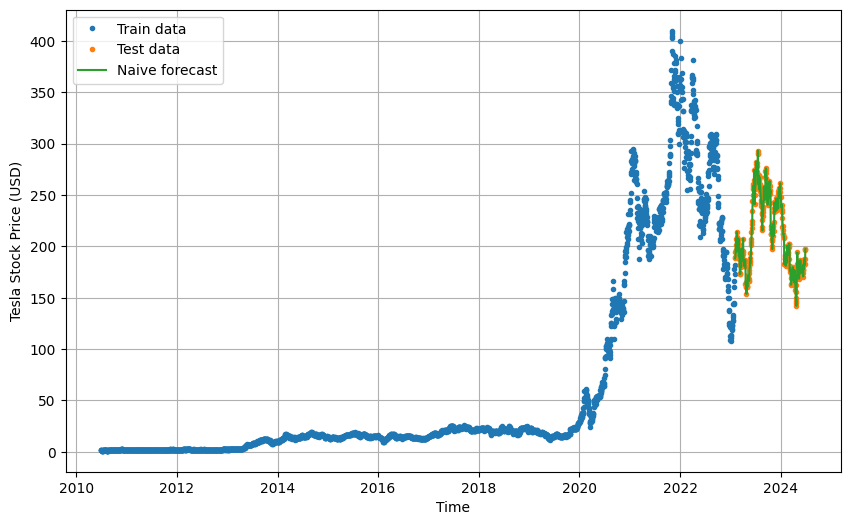

In [88]:
# Plot naive forecast
plt.figure(figsize=(10, 6))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast")

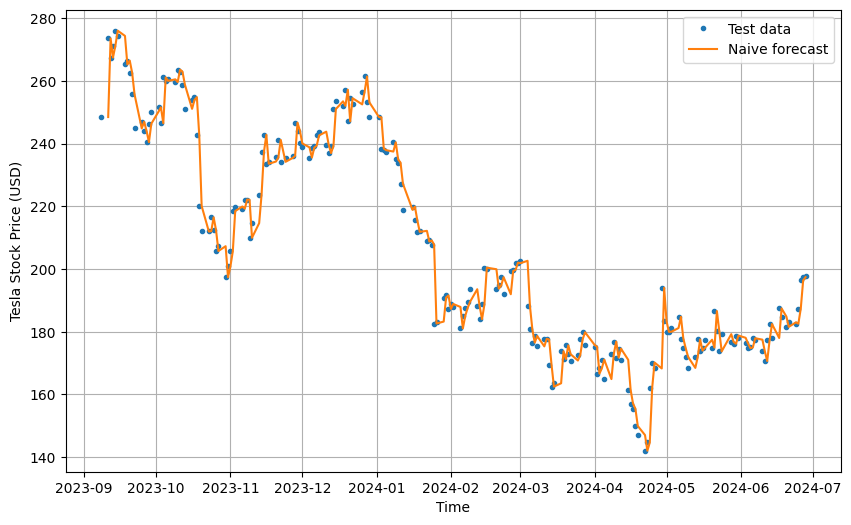

In [90]:
# Plot naive forecast with test data
plt.figure(figsize=(10, 6))
plot_time_series(timesteps=X_test, values=y_test, start=150, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=150, format="-", label="Naive forecast")

In [106]:
# Evaluating the model
import tensorflow as tf

# MASE (Mean absolute scaled error)
def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

def evaluate_model(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Initialize metric objects
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()
    mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()

    # Update metric states
    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)
    mape_metric.update_state(y_true, y_pred)

    # Compute metrics
    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    rmse = tf.sqrt(mse).numpy()
    mape = mape_metric.result().numpy()
    mase = mean_absolute_scaled_error(y_true, y_pred).numpy()

    return {"mae": mae,
            "mse": mse,
            "rmse": rmse,
            "mape": mape,
            "mase": mase}

In [107]:
naive_results = evaluate_model(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 4.944517,
 'mse': 44.496307,
 'rmse': 6.670555,
 'mape': 2.3657055,
 'mase': 0.9981398}

### Formatting data: Windowing dataset

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]

In [109]:
len(y_train)

3171

In [121]:
# Target data
print(f"Want to use this data: {list(prices[:7])} to predict this: {prices[7]}")

Want to use this data: [1.5926669836044312, 1.5886670351028442, 1.4639999866485596, 1.2799999713897705, 1.0740000009536743, 1.053333044052124, 1.1640000343322754] to predict this: 1.159999966621399


In [248]:
# Setup global variables for windows and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of data to make prediction

In [249]:
# Create function to label windowed data
def get_labelled_window(x, horizon):
    """
    Creates labels for windowed dataset.

    E.g. if horizon = 1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [250]:
tf.expand_dims(tf.range(8)+1, axis=0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7, 8]])>

In [251]:
# Test out the window labelling function
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]])>)

In [252]:
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [253]:
# Create function to view numpy arrays as windows
import numpy as np

def make_windows(x, window_size, horizon):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_window(windowed_array, horizon=horizon)

    # print(f"Window indexes:\n {window_indexes}")
    # print(f"Shape:\n {window_indexes.shape}")
    # print(f"Windowed array:\n {windowed_array}")

    return windows, labels

In [254]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [255]:
len(full_windows), len(full_labels)

(3517, 3517)

In [256]:
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [1.59266698 1.58866704 1.46399999 1.27999997 1.074      1.05333304
 1.16400003] -> Label: [1.15999997]
Window: [1.58866704 1.46399999 1.27999997 1.074      1.05333304 1.16400003
 1.15999997] -> Label: [1.13666701]
Window: [1.46399999 1.27999997 1.074      1.05333304 1.16400003 1.15999997
 1.13666701] -> Label: [1.20933294]


In [257]:
full_windows[:5], full_labels[:5]

(array([[1.59266698, 1.58866704, 1.46399999, 1.27999997, 1.074     ,
         1.05333304, 1.16400003],
        [1.58866704, 1.46399999, 1.27999997, 1.074     , 1.05333304,
         1.16400003, 1.15999997],
        [1.46399999, 1.27999997, 1.074     , 1.05333304, 1.16400003,
         1.15999997, 1.13666701],
        [1.27999997, 1.074     , 1.05333304, 1.16400003, 1.15999997,
         1.13666701, 1.20933294],
        [1.074     , 1.05333304, 1.16400003, 1.15999997, 1.13666701,
         1.20933294, 1.322667  ]]),
 array([[1.15999997],
        [1.13666701],
        [1.20933294],
        [1.322667  ],
        [1.32599998]]))

In [258]:
len(full_windows)

3517

In [259]:
# Make the train/test split
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [260]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.1)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3165, 352, 3165, 352)

In [261]:
# Create a function to implement checkpoint
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name + ".keras"),
                                              monitor="val_loss",
                                              verbose=0,
                                              save_best_only=True)

In [262]:
# Create function to predict on test dataset
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data.
    """
    preds = model.predict(input_data)
    return tf.squeeze(preds)

### Model 1: Dense model (window = 7, horizon = 1)

In [263]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["mae", "mse"])

model_1.fit(x=train_windows, 
            y=train_labels, 
            epochs=100, 
            verbose=1, 
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 29.9319 - mae: 29.9319 - mse: 4085.1379 - val_loss: 22.0265 - val_mae: 22.0265 - val_mse: 646.7877
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1839 - mae: 4.1839 - mse: 101.5447 - val_loss: 9.8467 - val_mae: 9.8467 - val_mse: 161.8696
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2310 - mae: 3.2310 - mse: 64.7090 - val_loss: 9.5384 - val_mae: 9.5384 - val_mse: 152.2822
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1310 - mae: 3.1310 - mse: 61.4079 - val_loss: 9.4688 - val_mae: 9.4688 - val_mse: 148.7268
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0267 - mae: 3.0267 - mse: 57.6590 - val_loss: 9.3274 - val_mae: 9.3274 - val_mse: 143.2932
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9427 - mae: 2.9427 - mse: 54.5095 - val_loss: 9.0357 - val_mae: 9.0357 - val_mse: 134.3773
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8464 - mae: 2.8464 

In [264]:
# Evaluate on test data
model_1.evaluate(test_windows, test_labels)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4497 - mae: 5.4497 - mse: 50.9830 


[5.203078269958496, 5.203078269958496, 48.45073318481445]

In [265]:
# Load in the saved best performing model_1
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3037 - mae: 5.3037 - mse: 48.5652  


[5.067882061004639, 5.067882061004639, 46.3068962097168]

In [266]:
# Make predictions using model_1
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([189.18109, 189.96092, 195.15038, 197.17664, 201.09618, 206.44334,
        198.36119, 193.82802, 206.2257 , 214.05934], dtype=float32)>,
 352)

In [267]:
# Evaluate preds
model_1_results = evaluate_model(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 5.067882,
 'mse': 46.306896,
 'rmse': 6.804917,
 'mape': 2.4232476,
 'mase': 1.0230433}

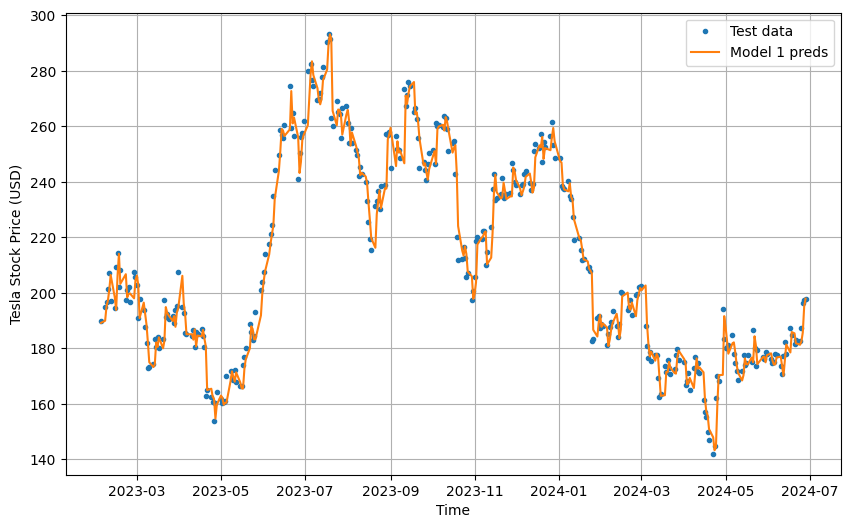

In [268]:
# Plot model 1 predictions
plt.figure(figsize=(10, 6))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, format="-", label="Model 1 preds")

### Model 2: Dense (window = 30, horizon = 1)

In [269]:
HORIZON = 1
WINDOW_SIZE = 30

In [270]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3494, 3494)

In [271]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.1)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3144, 350, 3144, 350)

In [272]:
train_windows[:3], train_labels[:3]

(array([[1.59266698, 1.58866704, 1.46399999, 1.27999997, 1.074     ,
         1.05333304, 1.16400003, 1.15999997, 1.13666701, 1.20933294,
         1.322667  , 1.32599998, 1.37600005, 1.46066701, 1.353333  ,
         1.34800005, 1.39999998, 1.41933298, 1.396667  , 1.37      ,
         1.38133299, 1.35666704, 1.32933295, 1.39466703, 1.46333301,
         1.41733301, 1.36333299, 1.30599999, 1.30666697, 1.26866698],
        [1.58866704, 1.46399999, 1.27999997, 1.074     , 1.05333304,
         1.16400003, 1.15999997, 1.13666701, 1.20933294, 1.322667  ,
         1.32599998, 1.37600005, 1.46066701, 1.353333  , 1.34800005,
         1.39999998, 1.41933298, 1.396667  , 1.37      , 1.38133299,
         1.35666704, 1.32933295, 1.39466703, 1.46333301, 1.41733301,
         1.36333299, 1.30599999, 1.30666697, 1.26866698, 1.19333303],
        [1.46399999, 1.27999997, 1.074     , 1.05333304, 1.16400003,
         1.15999997, 1.13666701, 1.20933294, 1.322667  , 1.32599998,
         1.37600005, 1.46066701,

In [273]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_2_dense")

model_2.compile(loss="mae", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["mae", "mse"])

model_2.fit(x=train_windows, 
            y=train_labels, 
            epochs=100, 
            verbose=1, 
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 37.5799 - mae: 37.5799 - mse: 7678.0259 - val_loss: 21.1198 - val_mae: 21.1198 - val_mse: 664.1560
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6975 - mae: 7.6975 - mse: 336.6990 - val_loss: 14.7334 - val_mae: 14.7334 - val_mse: 379.6522
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6794 - mae: 4.6794 - mse: 129.3497 - val_loss: 16.4977 - val_mae: 16.4977 - val_mse: 397.9549
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0959 - mae: 4.0959 - mse: 96.5532 - val_loss: 9.5513 - val_mae: 9.5513 - val_mse: 153.5874
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3368 - mae: 3.3368 - mse: 66.5100 - val_loss: 9.2335 - val_mae: 9.2335 - val_mse: 136.8715
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0469 - mae: 3.0469 - mse: 54.7987 - val_loss: 8.2836 - val_mae: 8.2836 - val_mse: 111.2595
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8292 - mae: 2.

In [274]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows, test_labels)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6372 - mae: 5.6372 - mse: 54.5408 


[5.486353874206543, 5.486353874206543, 53.426998138427734]

In [275]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6372 - mae: 5.6372 - mse: 54.5408  


[5.486353874206543, 5.486353874206543, 53.426998138427734]

In [277]:
model_2_preds = make_preds(model_2, test_windows)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [278]:
model_2_results = evaluate_model(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 5.486354,
 'mse': 53.427002,
 'rmse': 7.3093777,
 'mape': 2.6227834,
 'mase': 1.1055514}

In [279]:
model_1_results

{'mae': 5.067882,
 'mse': 46.306896,
 'rmse': 6.804917,
 'mape': 2.4232476,
 'mase': 1.0230433}